In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 2s - loss: 0.6513 - accuracy: 0.6094 - val_loss: 0.5338 - val_accuracy: 0.7910 - 2s/epoch - 3ms/step
Epoch 2/10
625/625 - 1s - loss: 0.4044 - accuracy: 0.8392 - val_loss: 0.3752 - val_accuracy: 0.8451 - 1s/epoch - 2ms/step
Epoch 3/10
625/625 - 1s - loss: 0.2978 - accuracy: 0.8820 - val_loss: 0.3486 - val_accuracy: 0.8568 - 1s/epoch - 2ms/step
Epoch 4/10
625/625 - 1s - loss: 0.2470 - accuracy: 0.9040 - val_loss: 0.3424 - val_accuracy: 0.8565 - 1s/epoch - 2ms/step
Epoch 5/10
625/625 - 1s - loss: 0.2115 - accuracy: 0.9190 - val_loss: 0.3502 - val_accuracy: 0.8523 - 977ms/epoch - 2ms/step
Epoch 6/10
625/625 - 1s - loss: 0.1842 - accuracy: 0.9302 - val_loss: 0.3590 - val_accuracy: 0.8557 - 967ms/epoch - 2ms/step
Epoch 7/10
625/625 - 1s - loss: 0.1634 - accuracy: 0.9395 - val_loss: 0.3725 - val_accuracy: 0.8562 - 915ms/epoch - 1ms/step
Epoch 8/10
625/625 - 1s - loss: 0.1453 - accuracy: 0.9458 - val_loss: 0.4090 - val_accuracy: 0.8420 - 898ms/epoch - 1ms/step
Epoch 9/10
6

In [10]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [11]:
reconstructed_model = tf.keras.models.load_model("saved_model")

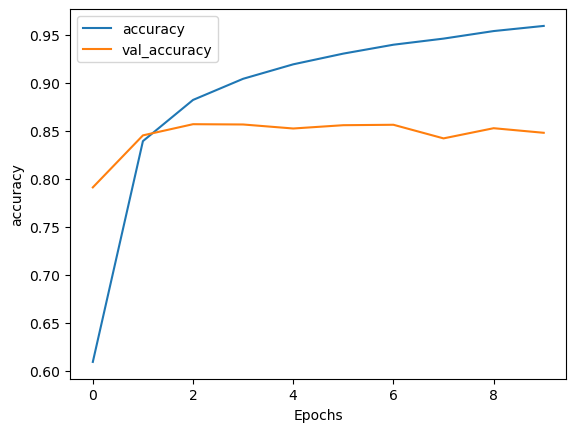

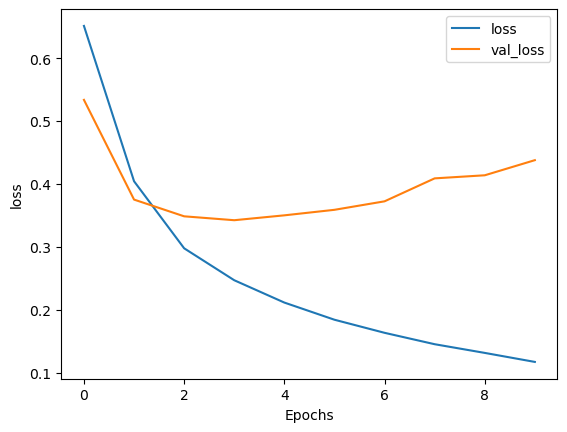

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
statement_input = input("BERT Model Prediction, enter statement ----> ")
sentence = [statement_input]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
if (reconstructed_model.predict(padded)[0] > 0.5):
    print(reconstructed_model.predict(padded)[0])
    print("Sarcastic")
else:
    print(reconstructed_model.predict(padded)[0])
    print("Not Sarcastic")

BERT Model Prediction, enter statement ----> Australia is a big country
1/1 [==============================] - 0s 29ms/step
[0.00150959]
Not Sarcastic
